# Exercise 11.1 

## Download Images

Go to the site (people.ee.ethz.ch/~maderk/aerial/) to download the two images needed for the exercise)
- ```ex_gt.tif```
- ```ex_im.tif```

## Import Libraries
Python requires importing libraries and functions you need to access specific tools like science (scipy), linear algebra (numpy), and graphics (matplotlib). These libraries can be installed using the ```pip``` command line tool. Alternatively you can install an python distribution like [Anaconda](https://www.continuum.io/downloads) or [Canopy](https://www.enthought.com/products/canopy/)  which have these and many other standard package pre-installed.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt # plotting
from skimage.io import imread # read in images
from skimage.segmentation import mark_boundaries # mark labels
from sklearn.metrics import roc_curve, auc # roc curve tools
from skimage.color import label2rgb
import numpy as np # linear algebra / matrices
# make the notebook interactive
from ipywidgets import interact, interactive, fixed 
import ipywidgets as widgets #add new widgets
from IPython.display import display

import os

In [5]:
base_path = '.'
seg_path = os.path.join(base_path,'ex_gt.tif')
rgb_path = os.path.join(base_path,'ex_im.tif')

seg_img = imread(seg_path)[:,:].astype(np.uint8)
rgb_img = imread(rgb_path)[:,:,:]

print('RGB Size',rgb_img.shape,'Seg Size',seg_img.shape)

RGB Size (1000, 1000, 3) Seg Size (1000, 1000)


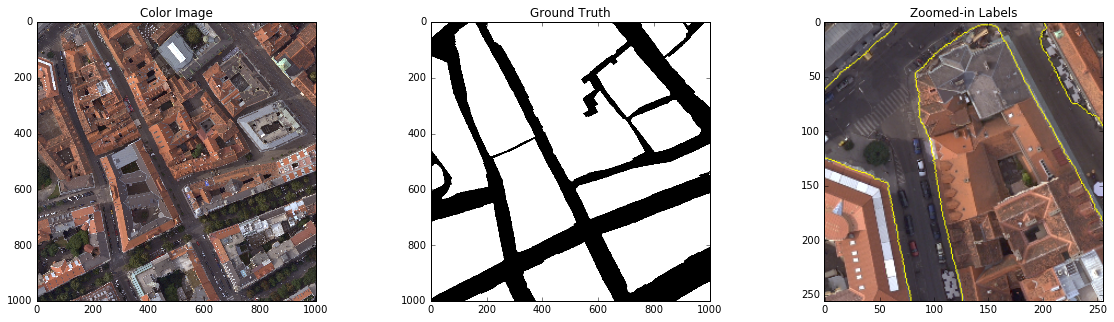

In [8]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5))
ax1.imshow(rgb_img) # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, cmap='gray') # show the segments
ax2.set_title("Ground Truth")
ax3.imshow(mark_boundaries(rgb_img,seg_img)[0:256,0:256,:])
ax3.set_title("Zoomed-in Labels")

## Creating a Simple ROC Curve
We use the score function of taking the mean of the red green and blue channels
$$ I = \frac{R+G+B}{3} $$
We then take the ```score``` by normalizing by the maximum value (since the image is 8bit this is 255)
$$ s = \frac{I}{255} $$

In [13]:
ground_truth_labels = seg_img.flatten()>0
score_value = np.mean(rgb_img.astype(np.float32),2).flatten()/255.0
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc = auc(fpr,tpr)

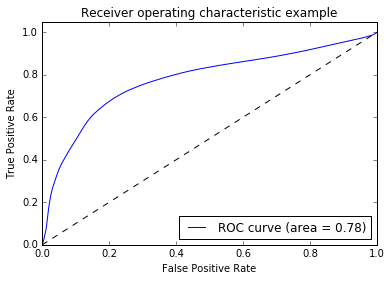

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Adding Filters
We can add a filter to this process by importing a ```uniform_filter``` and applying it before processing the image


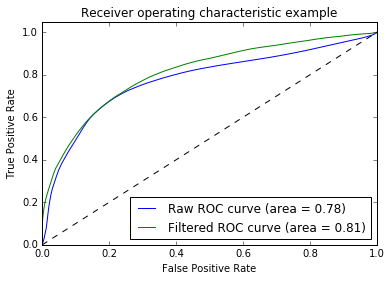

In [16]:
%matplotlib inline
from scipy.ndimage.filters import uniform_filter
filter_size = 45
filtered_image = uniform_filter(np.mean(rgb_img,2),filter_size)
score_value = filtered_image.astype(np.float32).flatten()/255.0
fpr2, tpr2, _ = roc_curve(ground_truth_labels,score_value)
roc_auc2 = auc(fpr2,tpr2)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fpr2, tpr2, label='Filtered ROC curve (area = %0.2f)' % roc_auc2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

### Tasks
1. How can you improve filtering in this analysis? 
 - Which filter elements might improve the area under the ROC?
 - Try making workflows to test out a few different filters
2. Where might morphological operations fit in?
 - How can you make them part of this workflow as well?
3. (Challenge) Try and use the optimize toolbox of _scipy_ with the fmin function (```from scipy.optimize import fmin```) to find the optimum parmeters for the highers area (hint: fmin finds the minimum value)

In [17]:
from scipy.optimize import fmin
def calc_auc(rv, gv, bv, fsize):
    filter_size = 45
    gray_image = (rv*rgb_img[:,:,0]+gv*rgb_img[:,:,1]+bv*rgb_img[:,:,2])/(rv+gv+bv)
    filtered_image = uniform_filter(gray_image,filter_size)
    score_value = filtered_image.astype(np.float32).flatten()/255.0
    fpr2, tpr2, _ = roc_curve(ground_truth_labels,score_value)
    return {'fpr':fpr2, 'tpr':tpr2, 'auc':auc(fpr2,tpr2), 'gimg': gray_image, 'fimg': filtered_image}

In [18]:
# test the function to make sure it works
min_func = lambda args: 1-calc_auc(*args)['auc']
min_start = [1,1,1,20]
min_func(min_start)

0.72975525706977895

In [19]:
opt_res = fmin(min_func,min_start)

Optimization terminated successfully.
         Current function value: 0.148528
         Iterations: 115
         Function evaluations: 237


In [20]:
opt_values = calc_auc(*opt_res)
tprOpt = opt_values['tpr']
fprOpt = opt_values['fpr']
roc_aucOpt = opt_values['auc']

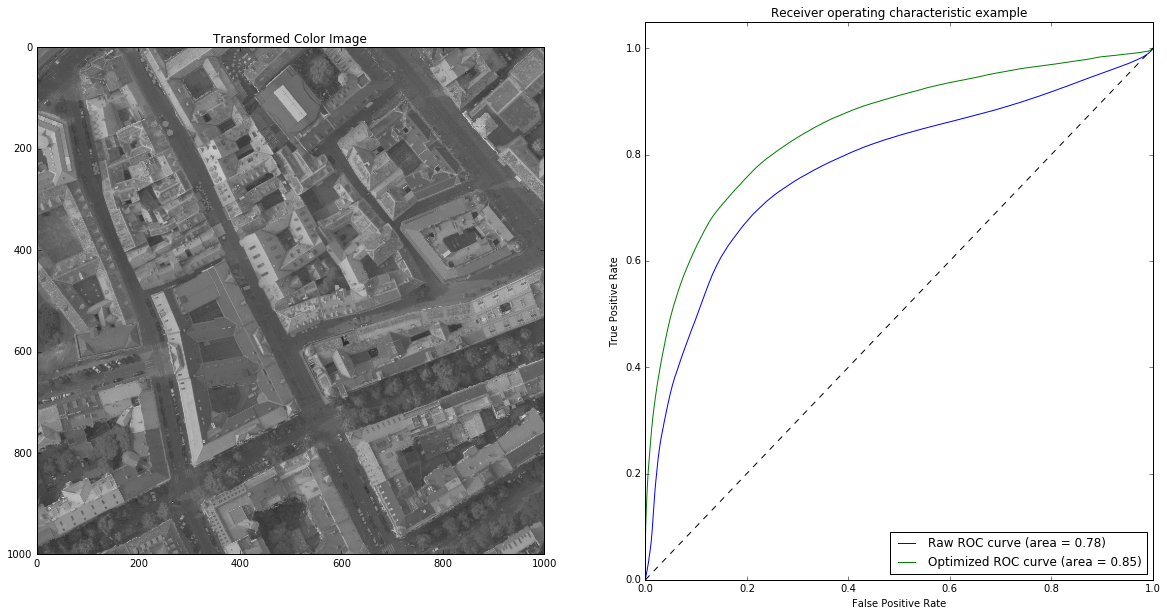

In [21]:
fig, (ax_img,ax) = plt.subplots(1,2, figsize = (20,10))
ax_img.imshow(opt_values['gimg'], cmap = 'gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Non-linear optimization
Here we use non-linear approaches to improve the quality of the results

In [22]:
def relu(x): 
    return (x+np.abs(x))/2
def calc_auc_nl(rv, rm, gv, gm, bv, bm):
    filter_size = 45
    gray_image = (rv*relu(rgb_img[:,:,0]/255.0-rm)+gv*relu(rgb_img[:,:,1]/255.0-gm)+
                  bv*relu(rgb_img[:,:,2]/255.0-bm))/(rv+gv+bv)
    score_value = gray_image.astype(np.float32).flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels,score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc':auc(fpr2,tpr2), 'gimg': gray_image, 'fimg': filtered_image}

In [23]:
# test the function to make sure it works
min_func = lambda args: 1-calc_auc_nl(*args)['auc']
min_start = [1,0,1,0,1,0]
min_start[0] = opt_res[0]
min_start[2] = opt_res[1]
min_start[4] = opt_res[2]
min_func(min_start)

0.18004549119433821

In [24]:
opt_res = fmin(min_func,min_start, maxiter = 100)

In [25]:
opt_values_nl = calc_auc_nl(*opt_res)
tprOpt_nl = opt_values_nl['tpr']
fprOpt_nl = opt_values_nl['fpr']
roc_aucOpt_nl = opt_values_nl['auc']

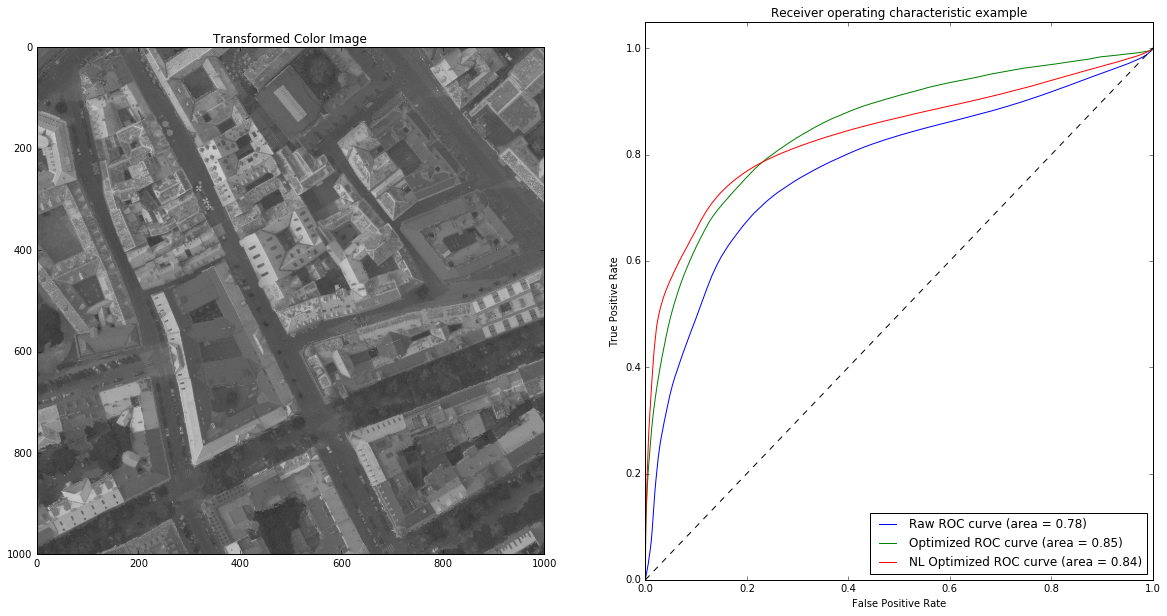

In [26]:
fig, (ax_img,ax) = plt.subplots(1,2, figsize = (20,10))
ax_img.imshow(opt_values_nl['gimg'], cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_nl, tprOpt_nl, label='NL Optimized ROC curve (area = %0.2f)' % roc_aucOpt_nl)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

# Next Steps
Rather than simply adjusting basic parameters, we can adjust entire arrays of information. The example below is the a convolutional neural network with one two layers

In [27]:
#from scipy.ndimage.filters import convolve
from scipy.signal import fftconvolve
convolve = lambda img1,img2: fftconvolve(img1,img2,mode='same')
CONV_SIZE = (20,20,1)
grey_img = np.reshape(np.mean(rgb_img,2)/255.0,(rgb_img.shape[0],rgb_img.shape[1],1))
def calc_auc_conv(rcoefs):
    coefs = rcoefs.reshape(CONV_SIZE)/rcoefs.sum()
    score_image = relu(convolve(grey_img,coefs))
    score_value = score_image.flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels,score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2,tpr2), 'gimg': score_image}

In [28]:
# test the function to make sure it works
min_func = lambda rcoefs: 1-calc_auc_conv(rcoefs)['auc']
min_start = np.zeros(CONV_SIZE)
min_start[10,10,0] = 1
min_func(min_start)

0.2232333517530235

In [29]:
%%time
opt_res_conv = fmin(min_func,min_start, maxiter = 100)

CPU times: user 3min 25s, sys: 52.1 s, total: 4min 17s
Wall time: 4min 19s


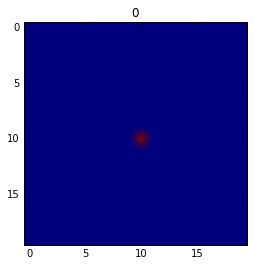

In [32]:
opt_values_conv = calc_auc_conv(opt_res_conv)
tprOpt_conv = opt_values_conv['tpr']
fprOpt_conv = opt_values_conv['fpr']
roc_aucOpt_conv = opt_values_conv['auc']
out_kernel = opt_res_conv.reshape(CONV_SIZE)/opt_res_conv.sum()
fig, ax_all = plt.subplots(1,out_kernel.shape[2])
for i,c_ax in enumerate(np.array(ax_all).flatten()):
    c_ax.imshow(out_kernel[:,:,i])
    c_ax.set_title(str(i))

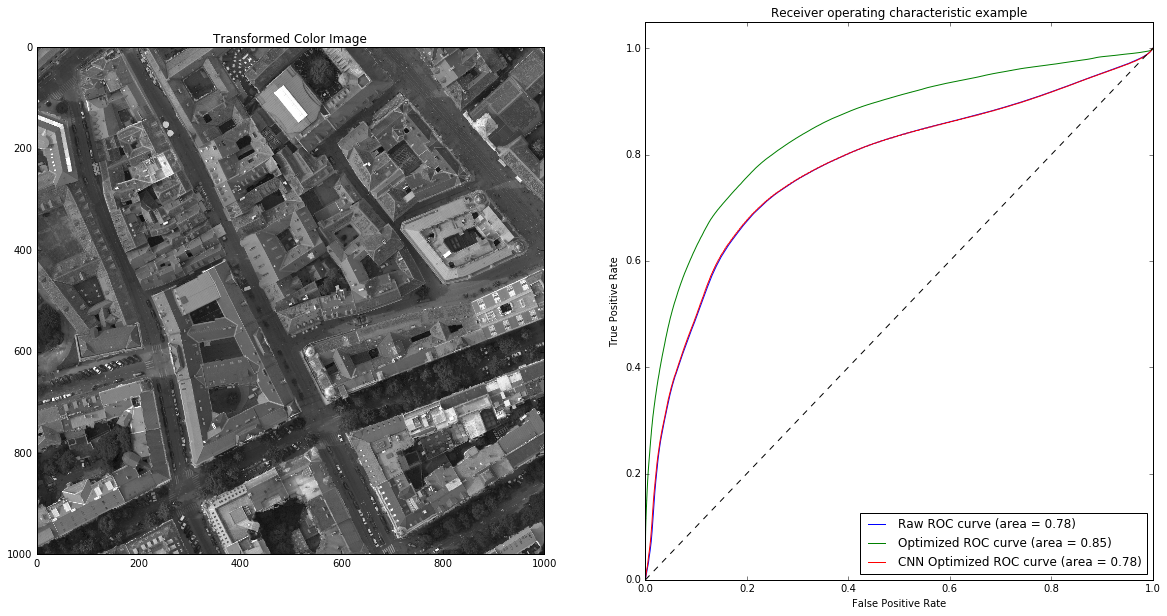

In [33]:
fig, (ax_img,ax) = plt.subplots(1,2, figsize = (20,10))
ax_img.imshow(opt_values_conv['gimg'].squeeze(), cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_conv, tprOpt_conv, label='CNN Optimized ROC curve (area = %0.2f)' % roc_aucOpt_conv)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## RGB CNN
Using the RGB instead of the gray value for the CNN

In [35]:
CONV_SIZE = (10,10,3)
def calc_auc_conv2d(rcoefs):
    coefs = rcoefs.reshape(CONV_SIZE)/rcoefs.sum()
    score_image = relu(convolve(grey_img,coefs))
    score_value = score_image.flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels,score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2,tpr2), 'gimg': score_image}

In [39]:
%%time
# test the function to make sure it works
min_func = lambda rcoefs: 1-calc_auc_conv2d(rcoefs)['auc']
min_start = np.random.rand(*CONV_SIZE)
for i in range(10): min_func(min_start)

CPU times: user 7.21 s, sys: 2.47 s, total: 9.68 s
Wall time: 9.73 s


In [40]:
%%time
opt_res_conv2d = fmin(min_func, min_start, maxfun = 2, maxiter = 1)
#opt_res_conv2d = min_start

CPU times: user 3min 52s, sys: 1min 24s, total: 5min 16s
Wall time: 5min 32s


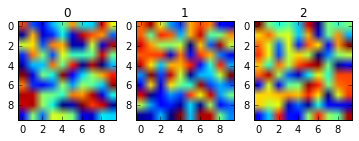

In [41]:
%matplotlib inline
opt_values_conv = calc_auc_conv2d(opt_res_conv2d)
tprOpt_conv = opt_values_conv['tpr']
fprOpt_conv = opt_values_conv['fpr']
roc_aucOpt_conv = opt_values_conv['auc']
out_kernel = opt_res_conv2d.reshape(CONV_SIZE)/opt_res_conv.sum()
fig, ax_all = plt.subplots(1,out_kernel.shape[2])
for i,c_ax in enumerate(np.array(ax_all).flatten()):
    c_ax.imshow(out_kernel[:,:,i])
    c_ax.set_title(str(i))
    

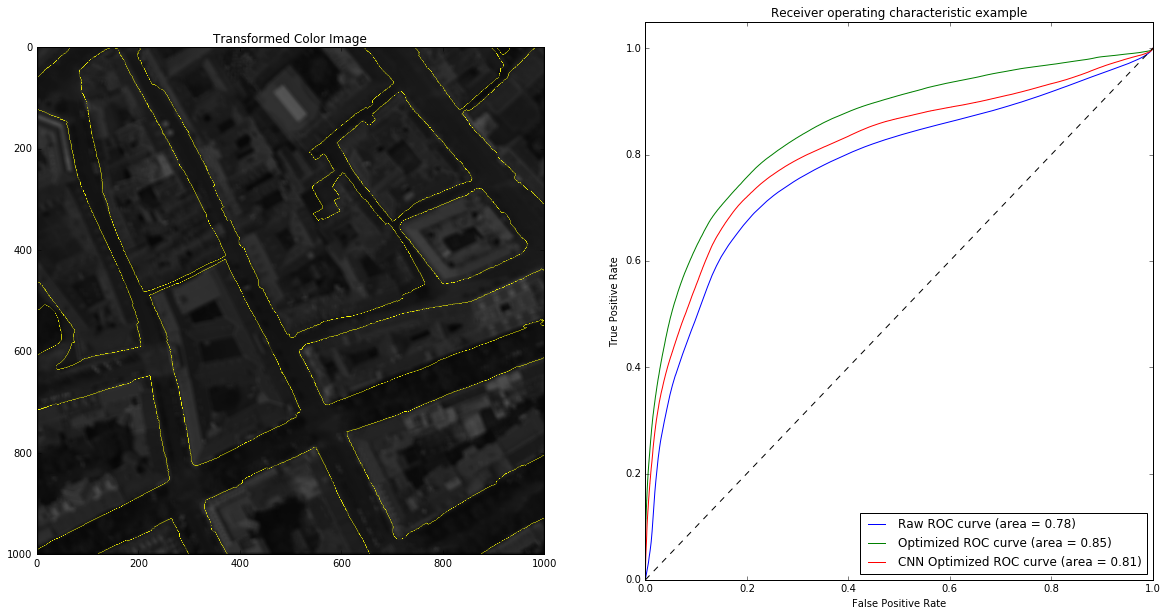

In [42]:
fig, (ax_img,ax) = plt.subplots(1,2, figsize = (20,10))
ax_img.imshow(mark_boundaries(opt_values_conv['gimg'].squeeze(),seg_img), cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_conv, tprOpt_conv, label='CNN Optimized ROC curve (area = %0.2f)' % roc_aucOpt_conv)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")